# Import Libraries

In [665]:
from helpers import SEABORN_COLORS, create_plot
import os
import sys
import time
import datetime

from termcolor import colored, cprint

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import sys
from os import listdir

import numpy as np
import pandas as pd  # Import Pandas and Numpy to create databases
import tensorflow as tf  # Import tensorflow to do tensor manipulations
from tensorflow import keras
from tensorflow.keras import Input, Model, layers, regularizers
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import csv
import statsmodels.api as sm
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# PathS

In [666]:
PATH_data = f"/mnt/d/UKB_toydata/"
PATH_GENO = f"{PATH_data}genotype"
PATH_usefull = f"{PATH_data}usefull_values_2"
PATH_PHENO = f"{PATH_data}phenotype"

In [667]:
disease = 'bc'
path = f"{PATH_usefull}/no_corr/{disease}"
sumstat = pd.read_pickle(f"{path}/sumstat.pkl")
pheno = pd.read_pickle(f"{path}/pheno_PRS.pkl")

In [668]:
sumstat

,snp,coef,std_err,Z,P,0.025,0.975,#CHROM,POS,-logp,cumulative_pos,SNP number
0,21:18780249:A_G_A,-0.010420,0.051082,-0.203986,0.838366,-0.110546,0.089706,21,18780249,0.176300,18780249,0
1,21:48029460:A_G_G,0.092894,0.055638,1.669614,0.095013,-0.016162,0.201950,21,48029460,2.353745,48029460,1
2,21:32179274:C_T_C,0.027381,0.067524,0.405506,0.685110,-0.104972,0.159735,21,32179274,0.378176,32179274,2
3,21:32169529:C_T_T,0.017939,0.066920,0.268060,0.788656,-0.113232,0.149109,21,32169529,0.237425,32169529,3
4,21:32186779:A_G_G,0.030418,0.061640,0.493472,0.621685,-0.090402,0.151237,21,32186779,0.475322,32186779,4
...,...,...,...,...,...,...,...,...,...,...,...,...
26995,22:44902759:A_G_A,0.004264,0.005163,0.825902,0.408870,-0.005856,0.014384,22,44902759,0.894357,92987579,26995
26996,22:19439165:C_T_C,0.007573,0.005164,1.466483,0.142534,-0.002549,0.017694,22,19439165,1.948177,67523985,26996
26997,22:19439540:A_G_G,0.007733,0.005164,1.497548,0.134268,-0.002389,0.017855,22,19439540,2.007919,67524360,26997
26998,22:39967785:C_G_G,0.003641,0.005174,0.703645,0.481663,-0.006501,0.013783,22,39967785,0.730511,88052605,26998


In [669]:
nr_significant_snps = 300
SNPS = sumstat.sort_values(by=['-logp'])[['snp','#CHROM']].tail(nr_significant_snps)
SNPS = SNPS.sort_values(by=['#CHROM'])
grouped = SNPS.groupby('#CHROM')

# Iterate over groups and create DataFrames
dataframes = {}
for name, group in grouped:
    dataframes[name] = group.copy()

name_file = "total_pop"
# Access each created DataFrame using the unique value as the key
genos_dfs = []
for chrom, dataframe in dataframes.items():
    print(f"DataFrame for chrom {chrom}:\n{dataframe}\n")
    # Define a function to extract ID from snp
    def extract_id(s):
        return s[:-2]  # Remove the last two characters

    # Apply the function to create the 'ID' column
    dataframe['ID'] = dataframe['snp'].apply(extract_id)
    snp_ids_to_keep = " ,".join(list(dataframe['ID']))
    path_total_pop = PATH_GENO + f"/02_per_chrom/total_pop_chr_{chrom}"
    os.system(f"plink2 --bfile {path_total_pop} --snps {snp_ids_to_keep} --recode A --out ./temp2")
    genos = pd.read_csv('./temp2.raw', sep="\t")
    genos = genos.fillna(0)
    to_drop = ['IID','PAT','MAT','SEX', 'PHENOTYPE']
    genos = genos.drop(to_drop, axis=1).astype(int) # encode it as (-1, 0, 1)
    genos_dfs.append(genos)
merged_df = genos_dfs[0]
for df in genos_dfs[1:]:
    merged_df = pd.merge(merged_df, df, on='FID')
merged_df

DataFrame for chrom 21:
                     snp #CHROM
7481   21:22313265:C_T_C     21
11139  21:23975186:A_C_A     21
8576   21:33651490:A_G_A     21
2253   21:36191365:A_G_G     21
11029  21:36080290:C_T_C     21
...                  ...    ...
8805   21:35979307:C_T_C     21
2681   21:33583062:C_G_G     21
12688  21:16263419:C_G_C     21
10395  21:36064321:C_T_T     21
1387   21:35554684:A_G_G     21

[109 rows x 2 columns]

PLINK v2.00a5LM 64-bit Intel (21 Jun 2023)     www.cog-genomics.org/plink/2.0/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ./temp2.log.
Options in effect:
  --bfile /mnt/d/UKB_toydata/genotype/02_per_chrom/total_pop_chr_21
  --export A
  --out ./temp2
  --snps 21:22313265:C_T ,21:23975186:A_C ,21:33651490:A_G ,21:36191365:A_G ,21:36080290:C_T ,21:47800628:A_G ,21:30986448:C_T ,21:45365248:C_G ,21:16353531:C_T ,21:36074558:A_C ,21:16288177:G_T ,21:34263801:A_G ,21:43865313:C_T ,21:35826877:C_T ,21:29362621:C_T ,21:36

--export A pass 1/1: loading... 1323769writing... 1010111112121313141415151616171718181920202121222223232424252526262727282829293030313132323333343435353636373738383940404141424243434444454546464747484849495050515152525353545455555656575758585960606161626263636464656566%66%67%67%68%68%69%69%70%70%71%71%72%72%73%73%74%74%75%75%76%76%77%77%78%78%79%80%80%81%81%82%82%83%83%84%84%85%85%86%86%87%87%88%88%89%89%90%90%91%91%92%92%93%93%94%94%95%95%96%96%97%97%98%98%99% done.
--export A: ./temp2.raw written.
End time: Mon Sep 18 15:54:43 2023


,FID,21:15711567:G_T_T,21:15720497:A_G_A,21:15999828:A_G_G,21:16263419:C_G_C,21:16263440:C_T_T,21:16266353:C_T_C,21:16288177:G_T_G,21:16295354:C_T_C,21:16298857:G_T_G,...,22:48273871:C_T_C,22:49179546:C_T_C,22:49331012:A_G_G,22:49336646:A_G_G,22:49803008:A_C_A,22:49803587:G_T_G,22:49911222:G_T_G,22:50456791:A_G_G,22:50457762:A_G_A,22:51091914:C_T_C
0,1000052,1,2,2,2,2,2,2,2,2,...,2,0,1,1,1,1,1,2,2,0
1,1000133,2,2,2,1,1,1,1,1,1,...,2,0,0,0,1,1,2,2,2,2
2,1000368,2,2,2,2,2,2,1,1,1,...,2,2,1,1,1,1,2,1,1,1
3,1000473,2,2,1,1,1,1,1,1,1,...,2,1,0,0,2,2,1,2,2,2
4,1000508,2,2,2,2,2,2,2,2,2,...,1,0,2,2,0,0,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69450,6026229,0,0,1,0,0,0,0,0,0,...,2,0,2,2,2,2,1,1,1,2
69451,6026253,2,2,2,0,0,0,0,0,0,...,2,2,2,2,2,2,1,2,2,1
69452,6026311,2,2,2,0,0,0,0,2,2,...,2,2,2,2,1,1,1,0,0,1
69453,6026378,2,2,2,0,0,0,0,0,1,...,2,1,2,2,1,1,0,2,2,1


In [670]:
geno = pd.merge(pheno[['FID','phenotype','PRS']], merged_df, on='FID')

In [671]:
geno

,FID,phenotype,PRS,21:15711567:G_T_T,21:15720497:A_G_A,21:15999828:A_G_G,21:16263419:C_G_C,21:16263440:C_T_T,21:16266353:C_T_C,21:16288177:G_T_G,...,22:48273871:C_T_C,22:49179546:C_T_C,22:49331012:A_G_G,22:49336646:A_G_G,22:49803008:A_C_A,22:49803587:G_T_G,22:49911222:G_T_G,22:50456791:A_G_G,22:50457762:A_G_A,22:51091914:C_T_C
0,1000133,1,-195.823928,2,2,2,1,1,1,1,...,2,0,0,0,1,1,2,2,2,2
1,1000368,1,264.081506,2,2,2,2,2,2,1,...,2,2,1,1,1,1,2,1,1,1
2,1000566,1,285.314179,2,2,2,1,1,1,2,...,2,1,2,2,2,2,2,2,2,2
3,1000617,1,-10.446365,1,1,2,2,2,2,1,...,1,1,2,2,1,1,1,1,1,1
4,1000655,0,-434.138697,2,2,2,1,1,1,1,...,1,0,2,2,2,2,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18450,6025070,1,953.791009,0,2,2,1,1,1,1,...,1,1,1,1,2,2,0,2,2,2
18451,6025369,1,-212.666886,2,2,2,1,1,1,1,...,1,1,2,2,1,1,0,2,2,1
18452,6025436,1,375.888514,2,2,2,1,1,1,1,...,1,2,1,1,1,1,0,2,2,2
18453,6025535,1,29.866073,2,2,1,1,1,1,2,...,1,2,2,2,2,2,2,2,2,2


In [672]:
# Split DataFrame into controls to train the model and cases and controls to calculate PRS
cases_df = geno[geno['phenotype'] == 1]
controls_df = geno[geno['phenotype'] == 0]
controls_df = controls_df.sample(frac=1, random_state=42)
train_controls = controls_df.head(len(controls_df)//2)
replicated_controls = controls_df.tail(len(controls_df) - len(controls_df)//2)
smallest_size = min(len(train_controls), len(replicated_controls), len(cases_df))


cases_df = cases_df.head(smallest_size)
train_controls = train_controls.head(smallest_size)
replicated_controls = replicated_controls.head(smallest_size)

In [673]:
geno

,FID,phenotype,PRS,21:15711567:G_T_T,21:15720497:A_G_A,21:15999828:A_G_G,21:16263419:C_G_C,21:16263440:C_T_T,21:16266353:C_T_C,21:16288177:G_T_G,...,22:48273871:C_T_C,22:49179546:C_T_C,22:49331012:A_G_G,22:49336646:A_G_G,22:49803008:A_C_A,22:49803587:G_T_G,22:49911222:G_T_G,22:50456791:A_G_G,22:50457762:A_G_A,22:51091914:C_T_C
0,1000133,1,-195.823928,2,2,2,1,1,1,1,...,2,0,0,0,1,1,2,2,2,2
1,1000368,1,264.081506,2,2,2,2,2,2,1,...,2,2,1,1,1,1,2,1,1,1
2,1000566,1,285.314179,2,2,2,1,1,1,2,...,2,1,2,2,2,2,2,2,2,2
3,1000617,1,-10.446365,1,1,2,2,2,2,1,...,1,1,2,2,1,1,1,1,1,1
4,1000655,0,-434.138697,2,2,2,1,1,1,1,...,1,0,2,2,2,2,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18450,6025070,1,953.791009,0,2,2,1,1,1,1,...,1,1,1,1,2,2,0,2,2,2
18451,6025369,1,-212.666886,2,2,2,1,1,1,1,...,1,1,2,2,1,1,0,2,2,1
18452,6025436,1,375.888514,2,2,2,1,1,1,1,...,1,2,1,1,1,1,0,2,2,2
18453,6025535,1,29.866073,2,2,1,1,1,1,2,...,1,2,2,2,2,2,2,2,2,2


In [674]:
to_drop = ['FID','phenotype','PRS']

In [675]:
geno_input = geno.drop(to_drop, axis=1).astype(int) -1

In [676]:
pheno_input = geno[['phenotype']]

# Create Model

In [677]:
input_shape_geno = geno_input.shape
input_layer_geno = Input(shape=input_shape_geno[1:], name='input_geno')

input_shape_pheno = pheno_input.shape
input_layer_pheno = Input(shape=input_shape_pheno[1:], name='input_pheno')

bottle = 35
size_layer_1 = int(round(input_shape_geno[1] + bottle)/2)

# Define your regularization strength (lambda)
l2_lambda = 0.001  # Adjust this value as needed

# Create layers

# Create layers
encoder_init_1 = layers.Dense(size_layer_1, 
                       activation="elu", 
                       name="encoder_init_1",
                       kernel_regularizer=regularizers.l2(l2_lambda))

encoder_init_2 = layers.Dense(bottle, 
                       activation="linear", 
                       name="encoder_init_2",
                       kernel_regularizer=regularizers.l2(l2_lambda))

decoder_init_1 = layers.Dense(size_layer_1, 
                       activation="elu", 
                       name="decoder_init_1",
                       kernel_regularizer=regularizers.l2(l2_lambda))

decoder_init_2 = layers.Dense(input_shape_geno[1], 
                       activation="linear", 
                       name="decoder_init_2",
                       kernel_regularizer=regularizers.l2(l2_lambda))



encoder_concat_1 = layers.Dense(size_layer_1, 
                       activation="elu", 
                       name="encoder_concat_1",
                       kernel_regularizer=regularizers.l2(l2_lambda))

encoder_concat_2 = layers.Dense(input_shape_pheno[1], 
                       activation="sigmoid", 
                       name="encoder_concat_2",
                       kernel_regularizer=regularizers.l2(l2_lambda))

decoder_concat_1 = layers.Dense(size_layer_1, 
                       activation="linear", 
                       name="decoder_concat_1",
                       kernel_regularizer=regularizers.l2(l2_lambda))

decoder_concat_2 = layers.Dense(input_shape_geno[1] + bottle, 
                       activation="linear", 
                       name="decoder_concat_2",
                       kernel_regularizer=regularizers.l2(l2_lambda))

In [678]:
bottle_neck = encoder_init_2(encoder_init_1(input_layer_geno))

In [679]:
concatenated_bottle = tf.concat([bottle_neck, input_layer_pheno], axis=1)
concatenated_inputs = tf.concat([bottle_neck, input_layer_geno], axis=1)

In [680]:
shape_zeros = concatenated_inputs.shape

In [681]:
#dec_init_1 = layers.BatchNormalization()(concatenated_bottle)
dec_init_1 = decoder_init_1(concatenated_bottle)

In [682]:
#dec_init_2 = layers.BatchNormalization()(dec_init_1)
X2 = decoder_init_2(dec_init_1)

In [683]:
y = encoder_concat_2(encoder_concat_1(concatenated_inputs))
conc_X2 = decoder_concat_2(decoder_concat_1(y))
squared_difference = tf.square(conc_X2 - concatenated_inputs)

In [684]:
model = Model(inputs = [input_layer_geno, input_layer_pheno], outputs = [X2, y, squared_difference], name = "fishy")

In [685]:
model.summary()

Model: "fishy"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_geno (InputLayer)        [(None, 300)]        0           []                               
                                                                                                  
 encoder_init_1 (Dense)         (None, 167)          50267       ['input_geno[0][0]']             
                                                                                                  
 encoder_init_2 (Dense)         (None, 35)           5880        ['encoder_init_1[0][0]']         
                                                                                                  
 tf.concat_13 (TFOpLambda)      (None, 335)          0           ['encoder_init_2[0][0]',         
                                                                  'input_geno[0][0]']         

In [686]:
genos = geno.sample(frac=1)
pheno = genos[['phenotype']].astype(int)
genos = genos.drop(to_drop, axis=1)
len_test = round(genos.shape[0]/10)*3
len_train = genos.shape[0] - len_test
X_train = genos.head(len_train) - 1
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_test = genos.tail(len_test) - 1
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)

shape_train = (len_train,squared_difference.shape[1])
shape_test = (len_test,squared_difference.shape[1])

In [687]:
pheno_tensor_train  = tf.convert_to_tensor(pheno.head(len_train))
pheno_tensor_test = tf.convert_to_tensor(pheno.tail(len_test))

In [688]:
pheno_tensor_train 

<tf.Tensor: shape=(12917, 1), dtype=int64, numpy=
array([[0],
       [1],
       [0],
       ...,
       [0],
       [0],
       [1]])>

In [689]:
epoch = 50

In [690]:
optimizer='Adam'
loss = 'mse'

In [691]:
zero_tensor_train = tf.zeros(shape_train, dtype=tf.float32)
zero_tensor_test = tf.zeros(shape_test, dtype=tf.float32) 

In [692]:
model.compile(optimizer,  loss=['mse', 'binary_crossentropy', 'mse'], metrics = ["mse"])

In [693]:
history = model.fit([X_train,pheno_tensor_train],
            [X_train, pheno_tensor_train, zero_tensor_train],
            validation_data=([X_test, pheno_tensor_test], 
                             [X_test, pheno_tensor_test, zero_tensor_test]),
            epochs = epoch,
            verbose = 1)

Epoch 1/50
404/404 [==============================] - 4s 6ms/step - loss: 1.7974 - decoder_init_2_loss: 0.2642 - encoder_concat_2_loss: 0.7145 - tf.math.square_6_loss: 0.2843 - decoder_init_2_mse: 0.2642 - encoder_concat_2_mse: 0.2586 - tf.math.square_6_mse: 0.2843 - val_loss: 1.4975 - val_decoder_init_2_loss: 0.2166 - val_encoder_concat_2_loss: 0.6967 - val_tf.math.square_6_loss: 0.2633 - val_decoder_init_2_mse: 0.2166 - val_encoder_concat_2_mse: 0.2514 - val_tf.math.square_6_mse: 0.2633
Epoch 2/50
404/404 [==============================] - 2s 5ms/step - loss: 1.4004 - decoder_init_2_loss: 0.2091 - encoder_concat_2_loss: 0.6831 - tf.math.square_6_loss: 0.2622 - decoder_init_2_mse: 0.2091 - encoder_concat_2_mse: 0.2450 - tf.math.square_6_mse: 0.2622 - val_loss: 1.3437 - val_decoder_init_2_loss: 0.2062 - val_encoder_concat_2_loss: 0.6833 - val_tf.math.square_6_loss: 0.2642 - val_decoder_init_2_mse: 0.2062 - val_encoder_concat_2_mse: 0.2451 - val_tf.math.square_6_mse: 0.2642
Epoch 3/50
4

Epoch 18/50
404/404 [==============================] - 2s 5ms/step - loss: 1.1956 - decoder_init_2_loss: 0.2049 - encoder_concat_2_loss: 0.6663 - tf.math.square_6_loss: 0.2574 - decoder_init_2_mse: 0.2049 - encoder_concat_2_mse: 0.2370 - tf.math.square_6_mse: 0.2574 - val_loss: 1.2210 - val_decoder_init_2_loss: 0.2062 - val_encoder_concat_2_loss: 0.6885 - val_tf.math.square_6_loss: 0.2592 - val_decoder_init_2_mse: 0.2062 - val_encoder_concat_2_mse: 0.2474 - val_tf.math.square_6_mse: 0.2592
Epoch 19/50
404/404 [==============================] - 2s 6ms/step - loss: 1.1951 - decoder_init_2_loss: 0.2047 - encoder_concat_2_loss: 0.6654 - tf.math.square_6_loss: 0.2573 - decoder_init_2_mse: 0.2047 - encoder_concat_2_mse: 0.2366 - tf.math.square_6_mse: 0.2573 - val_loss: 1.2328 - val_decoder_init_2_loss: 0.2051 - val_encoder_concat_2_loss: 0.7013 - val_tf.math.square_6_loss: 0.2591 - val_decoder_init_2_mse: 0.2051 - val_encoder_concat_2_mse: 0.2530 - val_tf.math.square_6_mse: 0.2591
Epoch 20/5

Epoch 35/50
404/404 [==============================] - 2s 6ms/step - loss: 1.1834 - decoder_init_2_loss: 0.2043 - encoder_concat_2_loss: 0.6503 - tf.math.square_6_loss: 0.2572 - decoder_init_2_mse: 0.2043 - encoder_concat_2_mse: 0.2295 - tf.math.square_6_mse: 0.2572 - val_loss: 1.2291 - val_decoder_init_2_loss: 0.2049 - val_encoder_concat_2_loss: 0.6939 - val_tf.math.square_6_loss: 0.2590 - val_decoder_init_2_mse: 0.2049 - val_encoder_concat_2_mse: 0.2497 - val_tf.math.square_6_mse: 0.2590
Epoch 36/50
404/404 [==============================] - 2s 5ms/step - loss: 1.1832 - decoder_init_2_loss: 0.2043 - encoder_concat_2_loss: 0.6498 - tf.math.square_6_loss: 0.2571 - decoder_init_2_mse: 0.2043 - encoder_concat_2_mse: 0.2293 - tf.math.square_6_mse: 0.2571 - val_loss: 1.2337 - val_decoder_init_2_loss: 0.2057 - val_encoder_concat_2_loss: 0.6954 - val_tf.math.square_6_loss: 0.2589 - val_decoder_init_2_mse: 0.2057 - val_encoder_concat_2_mse: 0.2506 - val_tf.math.square_6_mse: 0.2589
Epoch 37/5

In [694]:
vals = model.history.history
vali = list(vals.keys())

In [695]:
vali

['loss',
 'decoder_init_2_loss',
 'encoder_concat_2_loss',
 'tf.math.square_6_loss',
 'decoder_init_2_mse',
 'encoder_concat_2_mse',
 'tf.math.square_6_mse',
 'val_loss',
 'val_decoder_init_2_loss',
 'val_encoder_concat_2_loss',
 'val_tf.math.square_6_loss',
 'val_decoder_init_2_mse',
 'val_encoder_concat_2_mse',
 'val_tf.math.square_6_mse']

In [696]:
loss = vals[vali[0]]
decoder_loss = vals[vali[1]]
encoder_loss = vals[vali[2]]
decoder_accuracy = vals[vali[3]]
decoder_mse = vals[vali[4]]
encoder_accuracy = vals[vali[5]]
encoder_mse = vals[vali[6]]

val_loss = vals[vali[7]]
val_decoder_loss = vals[vali[8]]
val_encoder_loss = vals[vali[9]]
val_decoder_accuracy = vals[vali[10]]
val_decoder_mse = vals[vali[11]]
val_encoder_accuracy = vals[vali[12]]
val_encoder_mse = vals[vali[13]]

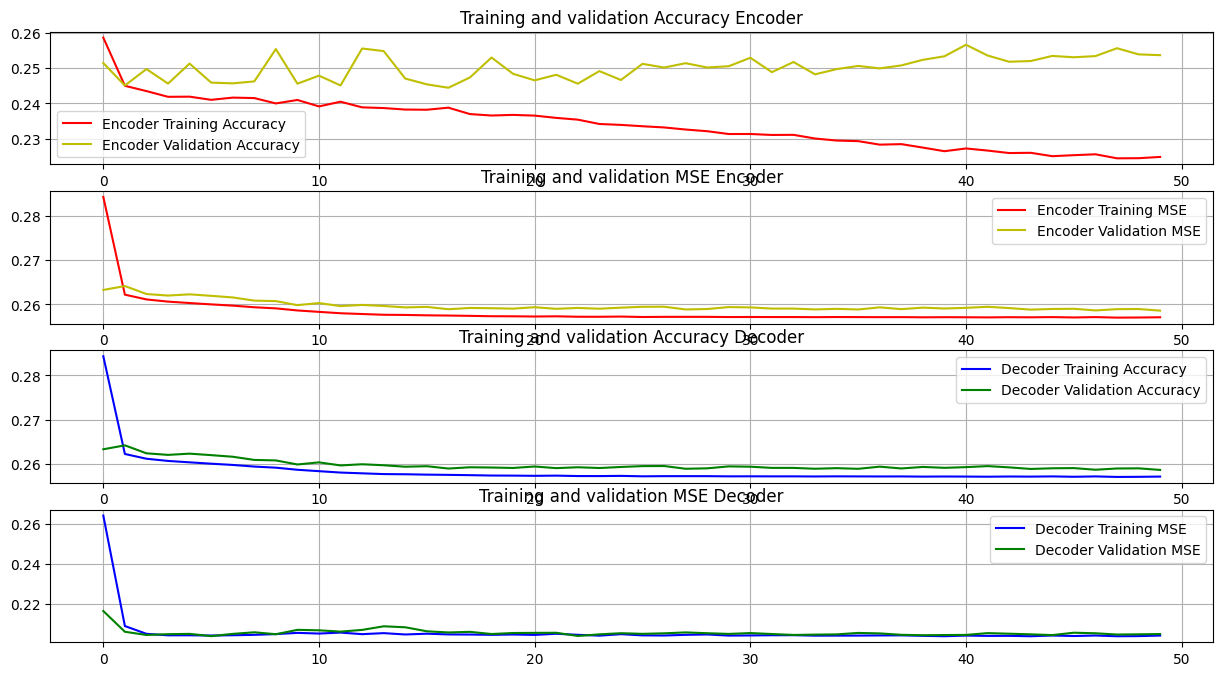

In [697]:
epochsticks = range(len(val_loss))
plt.figure(figsize = (15, 10))
ax1 = plt.subplot(511)
ax1.plot(epochsticks, encoder_accuracy, 'r', label = 'Encoder Training Accuracy')
ax1.plot(epochsticks, val_encoder_accuracy, 'y', label = 'Encoder Validation Accuracy')
ax1.set_title('Training and validation Accuracy Encoder')
ax1.grid()
ax1.legend()

ax2 = plt.subplot(512, sharex = ax1)
ax2.plot(epochsticks, encoder_mse, 'r', label = 'Encoder Training MSE')
ax2.plot(epochsticks, val_encoder_mse, 'y', label = 'Encoder Validation MSE')
ax2.set_title('Training and validation MSE Encoder')
ax2.grid()
ax2.legend()

ax3 = plt.subplot(513, sharex = ax1)
ax3.plot(epochsticks, decoder_accuracy, 'b', label = 'Decoder Training Accuracy')
ax3.plot(epochsticks, val_decoder_accuracy, 'g', label = 'Decoder Validation Accuracy')
ax3.set_title('Training and validation Accuracy Decoder')
ax3.grid()
ax3.legend()

ax4 = plt.subplot(514, sharex = ax1)

ax4.plot(epochsticks, decoder_mse, 'b', label = 'Decoder Training MSE')
ax4.plot(epochsticks, val_decoder_mse, 'g', label = 'Decoder Validation MSE')
ax4.set_title('Training and validation MSE Decoder')
ax4.grid()
ax4.legend()

In [698]:
X = tf.convert_to_tensor(geno, dtype=tf.float32)

In [699]:
pheno = geno[['phenotype']].astype(int)
genos = geno.drop(to_drop, axis=1) - 1 

In [700]:
X1 = tf.convert_to_tensor(genos, dtype=tf.float32)
X2 = tf.convert_to_tensor(pheno, dtype=tf.float32)

In [701]:
output_model = model([X1,X2])

In [702]:
output_model

[<tf.Tensor: shape=(18455, 300), dtype=float32, numpy=
 array([[0.6686464 , 0.7325278 , 0.7470695 , ..., 0.49995324, 0.45114717,
         0.5452275 ],
        [0.71755636, 0.7709594 , 0.7317193 , ..., 0.5387871 , 0.49229   ,
         0.57395506],
        [0.67592114, 0.73569006, 0.7735693 , ..., 0.48190036, 0.42417413,
         0.5416519 ],
        ...,
        [0.67840236, 0.7463939 , 0.7092018 , ..., 0.5144314 , 0.45370382,
         0.52777505],
        [0.68956   , 0.7589572 , 0.70958817, ..., 0.5099473 , 0.47104517,
         0.5587167 ],
        [0.721321  , 0.7836529 , 0.743313  , ..., 0.5199133 , 0.48670533,
         0.5800758 ]], dtype=float32)>,
 <tf.Tensor: shape=(18455, 1), dtype=float32, numpy=
 array([[0.6310325 ],
        [0.7534373 ],
        [0.5780498 ],
        ...,
        [0.5498493 ],
        [0.48633456],
        [0.4961236 ]], dtype=float32)>,
 <tf.Tensor: shape=(18455, 335), dtype=float32, numpy=
 array([[0.28823856, 0.28819272, 0.00405735, ..., 0.45148307, 0.483

In [703]:
submodel_layers1 = model.layers[:3]
submodel1 = Model(inputs=[model.input[0]], outputs=submodel_layers1[-1].output)
submodel1(X1)

<tf.Tensor: shape=(18455, 35), dtype=float32, numpy=
array([[-0.5491274 ,  0.5480526 ,  0.0370757 , ..., -0.01073992,
        -0.45712548,  0.06572753],
       [ 0.11966155, -0.12089041,  0.64740825, ..., -0.30063018,
        -0.6025579 ,  0.67837334],
       [-0.53140527,  0.53029084,  0.5953046 , ..., -0.27565667,
        -0.5516458 ,  0.62664866],
       ...,
       [-0.39767867,  0.39641476,  0.6954186 , ..., -0.08273299,
        -0.0443774 ,  0.7264482 ],
       [-0.4220832 ,  0.4209975 ,  0.12860972, ..., -0.32254505,
         0.0941459 ,  0.15554774],
       [ 0.1440255 , -0.1445597 , -0.2297355 , ...,  0.05572026,
        -0.56199044, -0.20624997]], dtype=float32)>

In [704]:
submodel_layers2 = model.layers[:6]
submodel2 = Model(inputs=[model.input[0]], outputs=submodel_layers2[-1].output)
submodel2(X1)

<tf.Tensor: shape=(18455, 1), dtype=float32, numpy=
array([[0.6310325 ],
       [0.7534373 ],
       [0.5780498 ],
       ...,
       [0.5498493 ],
       [0.48633456],
       [0.4961236 ]], dtype=float32)>

In [705]:
submodel_layers3 = model.layers[:16]
submodel3 = Model(inputs=[model.input[0]], outputs=submodel_layers3[-1].output)
submodel3(X1)

<tf.Tensor: shape=(18455, 335), dtype=float32, numpy=
array([[0.28823856, 0.28819272, 0.00405735, ..., 0.45148307, 0.48303676,
        0.4235114 ],
       [0.01739804, 0.01745002, 0.29879278, ..., 0.10763934, 0.09302238,
        0.12197601],
       [0.2695194 , 0.269434  , 0.24456829, ..., 0.45148844, 0.48303932,
        0.42352727],
       ...,
       [0.1485516 , 0.14837307, 0.35361588, ..., 0.4514913 , 0.48304066,
        0.42353567],
       [0.1679556 , 0.16791186, 0.00077593, ..., 0.4514977 , 0.48304364,
        0.42355475],
       [0.02442473, 0.02426928, 0.10922433, ..., 0.45149675, 0.48304313,
        0.12193465]], dtype=float32)>

In [706]:
 model.layers

In [707]:
pheno

,phenotype
0,1
1,1
2,1
3,1
4,0
...,...
18450,1
18451,1
18452,1
18453,1


In [708]:
cols = []
for i2 in range(np.shape(submodel1(X1))[1]):
    cols.append(f'dim{i2+1}')
bottleneck_1 = pd.DataFrame(submodel1(X1), columns = cols)
cols = []
for i2 in range(np.shape(submodel2(X1))[1]):
    cols.append(f'pheno{i2+1}')
predicted_pheno = pd.DataFrame(submodel2(X1), columns = cols)

In [709]:
merged_pheno = pheno.join(bottleneck_1.join(predicted_pheno))
merged_pheno

,phenotype,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,...,dim27,dim28,dim29,dim30,dim31,dim32,dim33,dim34,dim35,pheno1
0,1,-0.549127,0.548053,0.037076,0.053558,0.277630,-0.004555,-0.499846,-0.369822,0.618115,...,-0.398311,-0.543898,0.414606,0.437788,0.628197,0.151417,-0.010740,-0.457125,0.065728,0.631033
1,1,0.119662,-0.120890,0.647408,-0.560161,-0.380651,-0.291598,0.222130,-0.444127,-0.053383,...,0.315442,0.128968,0.490611,-0.454605,-0.042558,0.763823,-0.300630,-0.602558,0.678373,0.753437
2,1,-0.531405,0.530291,0.595305,0.233534,-0.509587,-0.266173,-0.725157,-0.828293,0.599230,...,-0.626357,-0.524595,0.872884,-0.484662,0.609607,0.716058,-0.275657,-0.551646,0.626649,0.578050
3,1,-0.476437,0.475658,-0.037231,-0.578000,-0.521294,-0.320531,-0.602179,0.425029,-0.031697,...,-0.505267,-0.471679,-0.381262,0.243385,-0.022384,0.068350,-0.331647,-0.011832,-0.011561,0.460403
4,0,0.194707,-0.195470,-0.027817,0.257138,-0.622777,-0.297269,-0.674367,0.417762,0.020963,...,-0.571669,0.195879,-0.373060,0.491131,0.029818,0.081296,-0.300333,0.254858,-0.000870,0.351554
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18450,1,0.273037,-0.273666,0.377559,0.059416,-0.504094,0.158992,-0.635212,0.516279,-0.750315,...,-0.532266,0.272817,-0.471883,0.505769,-0.742160,0.486229,0.157175,-0.610220,0.403909,0.579562
18451,1,0.160634,-0.161393,0.643606,0.265816,-0.568302,-0.050539,-0.629771,-0.359507,0.516933,...,-0.527135,0.161822,0.402186,0.470975,0.525385,0.754220,-0.054010,-0.583928,0.670979,0.558598
18452,1,-0.397679,0.396415,0.695419,0.439486,0.080170,-0.073509,0.396562,-0.299697,0.543835,...,0.493124,-0.386786,0.346251,0.505314,0.555108,0.810678,-0.082733,-0.044377,0.726448,0.549849
18453,1,-0.422083,0.420998,0.128610,-0.473417,-0.174030,-0.315054,0.339167,-0.454795,-0.175759,...,0.431850,-0.413406,0.498283,0.437550,-0.165721,0.232330,-0.322545,0.094146,0.155548,0.486335


<module 'matplotlib.pyplot' from '/home/mat2m10/.pyenv/versions/3.10.6/envs/ctg/lib/python3.10/site-packages/matplotlib/pyplot.py'>

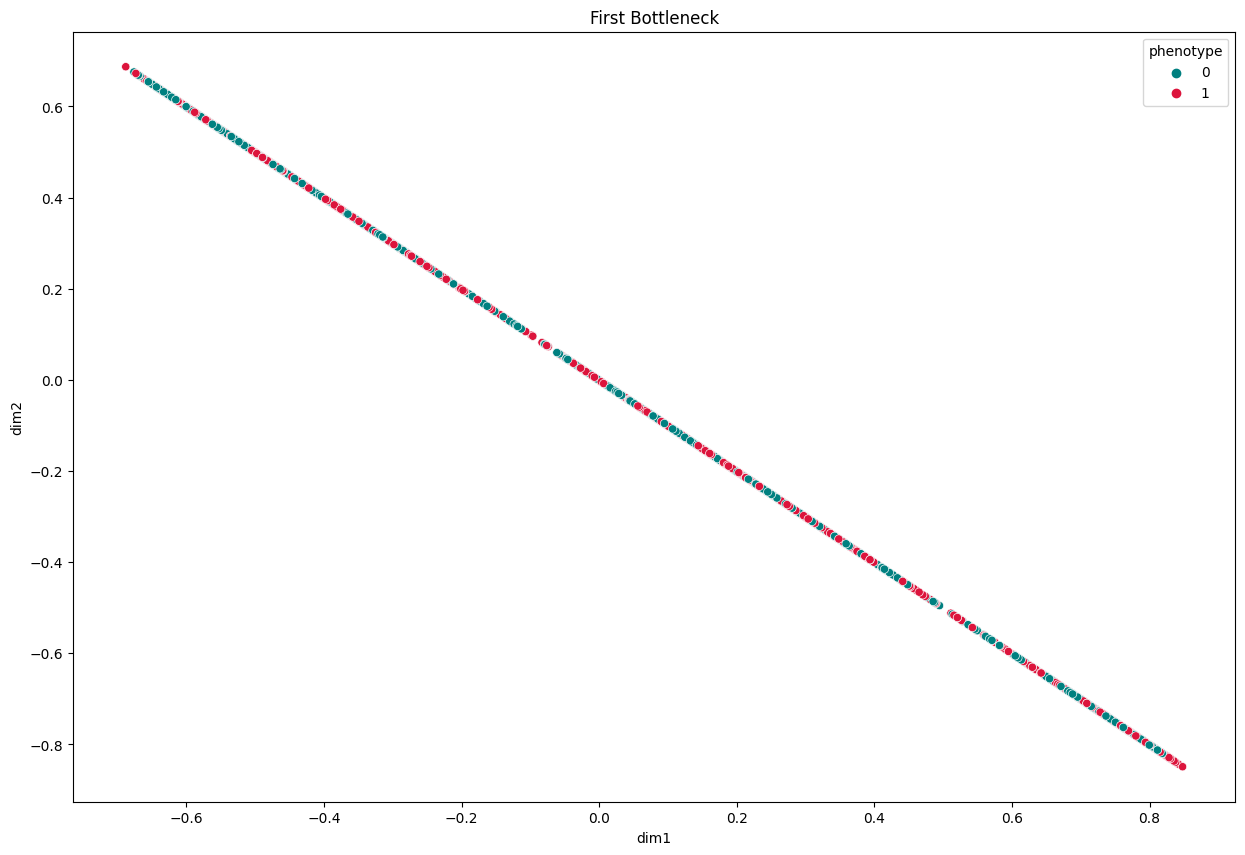

In [710]:
create_plot(merged_pheno['phenotype'], merged_pheno, 'dim1', 'dim2', 'First Bottleneck')

<module 'matplotlib.pyplot' from '/home/mat2m10/.pyenv/versions/3.10.6/envs/ctg/lib/python3.10/site-packages/matplotlib/pyplot.py'>

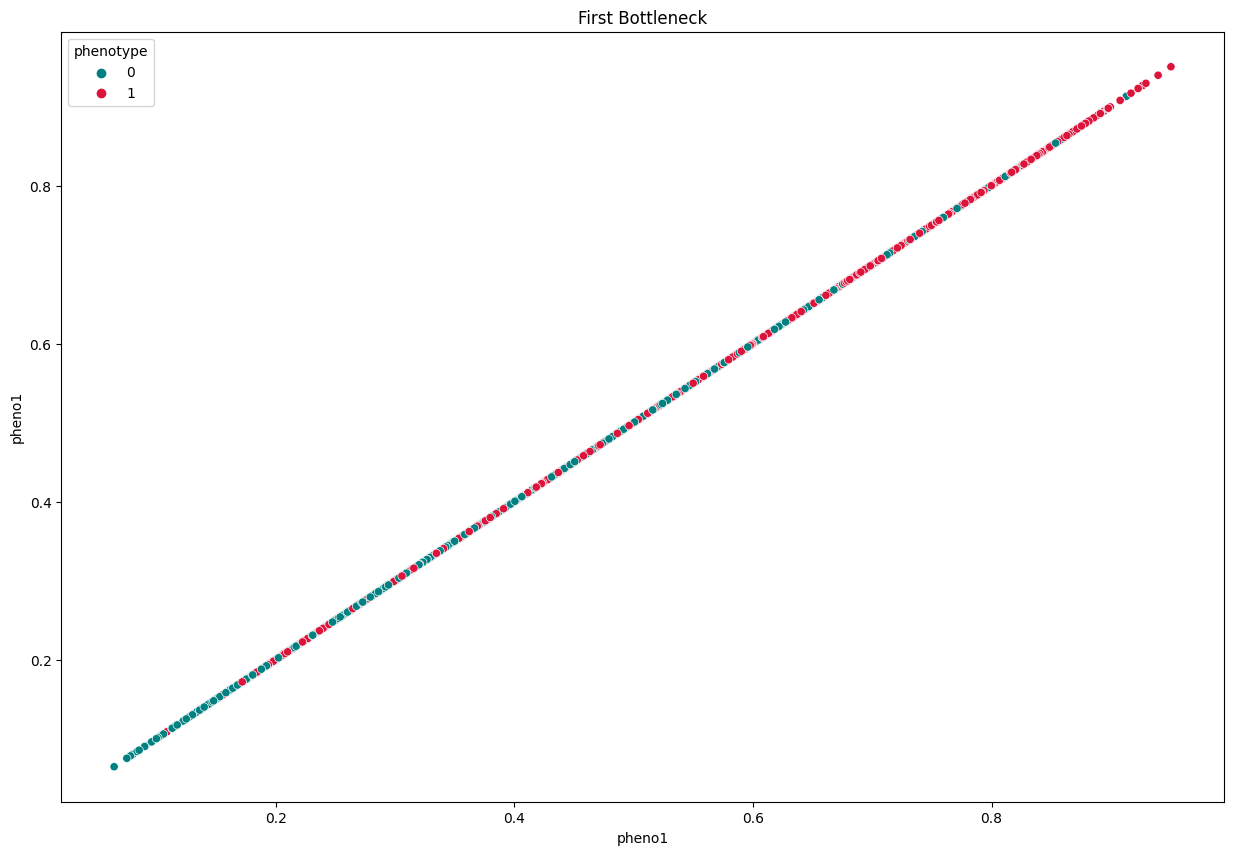

In [711]:
create_plot(merged_pheno['phenotype'], merged_pheno, 'pheno1', 'pheno1', 'First Bottleneck')

In [712]:
genos

,21:15711567:G_T_T,21:15720497:A_G_A,21:15999828:A_G_G,21:16263419:C_G_C,21:16263440:C_T_T,21:16266353:C_T_C,21:16288177:G_T_G,21:16295354:C_T_C,21:16298857:G_T_G,21:16353531:C_T_T,...,22:48273871:C_T_C,22:49179546:C_T_C,22:49331012:A_G_G,22:49336646:A_G_G,22:49803008:A_C_A,22:49803587:G_T_G,22:49911222:G_T_G,22:50456791:A_G_G,22:50457762:A_G_A,22:51091914:C_T_C
0,1,1,1,0,0,0,0,0,0,1,...,1,-1,-1,-1,0,0,1,1,1,1
1,1,1,1,1,1,1,0,0,0,1,...,1,1,0,0,0,0,1,0,0,0
2,1,1,1,0,0,0,1,1,1,1,...,1,0,1,1,1,1,1,1,1,1
3,0,0,1,1,1,1,0,0,0,1,...,0,0,1,1,0,0,0,0,0,0
4,1,1,1,0,0,0,0,1,1,1,...,0,-1,1,1,1,1,-1,-1,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18450,-1,1,1,0,0,0,0,0,0,-1,...,0,0,0,0,1,1,-1,1,1,1
18451,1,1,1,0,0,0,0,0,0,1,...,0,0,1,1,0,0,-1,1,1,0
18452,1,1,1,0,0,0,0,0,0,1,...,0,1,0,0,0,0,-1,1,1,1
18453,1,1,0,0,0,0,1,1,1,1,...,0,1,1,1,1,1,1,1,1,1


In [713]:
pheno

,phenotype
0,1
1,1
2,1
3,1
4,0
...,...
18450,1
18451,1
18452,1
18453,1


In [714]:
PRS = np.array([0] * pheno.shape[0])
snps = []
coefs = []
std_errs = []
ts = []
Ps = []
twfives = []
ninfives = []
for snp_id in list(genos.columns):
                #print('-------------------')
                #print(snp_id)
                #print(genos[snp_id])
                X2 = sm.add_constant(genos[[snp_id]])
                est = sm.OLS(pheno[['phenotype']], X2)
                est2 = est.fit()
                snps.append(est2.pvalues.index[1])
                coefs.append(est2.params[1])
                std_errs.append(est2.bse[1])
                ts.append(est2.tvalues[1])

                P = est2.pvalues[1]
                logp = - np.log(P)
                if logp > 0:
                    PRS = PRS + np.array(est2.tvalues[1]*genos[snp_id])
                else:
                    pass
                Ps.append(P)
                twfives.append(est2.conf_int()[0][1])
                ninfives.append(est2.conf_int()[1][1])
sumstat = pd.DataFrame(data={
            'snp': snps,
            'coef': coefs,
            'std_err': std_errs,
            'Z': ts,
            'P': Ps,
            '0.025': twfives,
            '0.975': ninfives
        })
sumstat['#CHROM'] = sumstat['snp'].str[:2].astype(int)
sumstat['POS'] = [i.split(':', 1)[0] for i in list(sumstat['snp'].str[3:-5])]
sumstat['POS'] = sumstat['POS'].astype(int)
sumstat['-logp'] = - np.log(sumstat['P'])

sumstat['#CHROM'] = [f.split(':')[0] for f in list(sumstat['snp'])]
sumstat['POS'] = [f.split(':')[1] for f in list(sumstat['snp'])]
sumstat['POS'] = sumstat['POS'].astype(int)
running_pos = 0
cumulative_pos = []
for chrom, group_df in sumstat.groupby('#CHROM'):
    cumulative_pos.append(group_df['POS'] + running_pos)
    running_pos += group_df['POS'].max()

sumstat['cumulative_pos'] = pd.concat(cumulative_pos)
sumstat['SNP number'] = sumstat.index

In [715]:
sumstat

,snp,coef,std_err,Z,P,0.025,0.975,#CHROM,POS,-logp,cumulative_pos,SNP number
0,21:15711567:G_T_T,0.019922,0.007051,2.825667,0.004723,0.006103,0.033742,21,15711567,5.355248,15711567,0
1,21:15720497:A_G_A,0.021591,0.007612,2.836533,0.004566,0.006671,0.036510,21,15720497,5.389206,15720497,1
2,21:15999828:A_G_G,-0.020910,0.007965,-2.625335,0.008664,-0.036521,-0.005298,21,15999828,4.748635,15999828,2
3,21:16263419:C_G_C,-0.013753,0.005181,-2.654322,0.007954,-0.023909,-0.003597,21,16263419,4.834130,16263419,3
4,21:16263440:C_T_T,-0.013967,0.005181,-2.695718,0.007030,-0.024123,-0.003811,21,16263440,4.957558,16263440,4
...,...,...,...,...,...,...,...,...,...,...,...,...
295,22:49803587:G_T_G,0.015397,0.005382,2.861027,0.004227,0.004849,0.025946,22,49803587,5.466155,97604215,295
296,22:49911222:G_T_G,-0.015250,0.005351,-2.850158,0.004375,-0.025738,-0.004762,22,49911222,5.431941,97711850,296
297,22:50456791:A_G_G,0.016424,0.005917,2.775823,0.005512,0.004826,0.028021,22,50456791,5.200872,98257419,297
298,22:50457762:A_G_A,0.015552,0.005807,2.678284,0.007407,0.004170,0.026934,22,50457762,4.905383,98258390,298


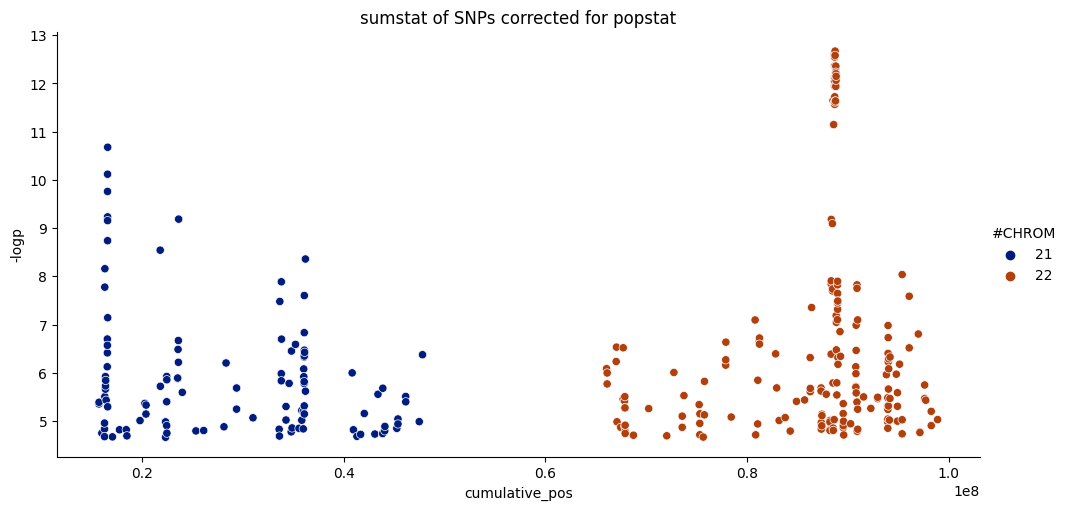

In [716]:
sns.relplot(
data = sumstat,
x = 'cumulative_pos',
y = '-logp',
aspect = 2,
hue = '#CHROM',
palette = 'dark'
).set(title=f"sumstat of SNPs corrected for popstat")
plt.show()

# Train only on cases

In [717]:
genos

,21:15711567:G_T_T,21:15720497:A_G_A,21:15999828:A_G_G,21:16263419:C_G_C,21:16263440:C_T_T,21:16266353:C_T_C,21:16288177:G_T_G,21:16295354:C_T_C,21:16298857:G_T_G,21:16353531:C_T_T,...,22:48273871:C_T_C,22:49179546:C_T_C,22:49331012:A_G_G,22:49336646:A_G_G,22:49803008:A_C_A,22:49803587:G_T_G,22:49911222:G_T_G,22:50456791:A_G_G,22:50457762:A_G_A,22:51091914:C_T_C
0,1,1,1,0,0,0,0,0,0,1,...,1,-1,-1,-1,0,0,1,1,1,1
1,1,1,1,1,1,1,0,0,0,1,...,1,1,0,0,0,0,1,0,0,0
2,1,1,1,0,0,0,1,1,1,1,...,1,0,1,1,1,1,1,1,1,1
3,0,0,1,1,1,1,0,0,0,1,...,0,0,1,1,0,0,0,0,0,0
4,1,1,1,0,0,0,0,1,1,1,...,0,-1,1,1,1,1,-1,-1,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18450,-1,1,1,0,0,0,0,0,0,-1,...,0,0,0,0,1,1,-1,1,1,1
18451,1,1,1,0,0,0,0,0,0,1,...,0,0,1,1,0,0,-1,1,1,0
18452,1,1,1,0,0,0,0,0,0,1,...,0,1,0,0,0,0,-1,1,1,1
18453,1,1,0,0,0,0,1,1,1,1,...,0,1,1,1,1,1,1,1,1,1


In [718]:
fids = geno[['FID']]

In [719]:
pheno = pd.read_pickle(f"{path}/pheno_PRS.pkl")

In [720]:
new = pd.concat([pheno[['phenotype']], bottleneck_1, genos], axis = 1)

In [721]:
# Split DataFrame into controls to train the model and cases and controls to calculate PRS
cases_df = new[new['phenotype'] == 1]
controls_df = new[new['phenotype'] == 0]
controls_df = controls_df.sample(frac=1, random_state=42)
train_controls = controls_df.head(len(controls_df)//2)
replicated_controls = controls_df.tail(len(controls_df) - len(controls_df)//2)
smallest_size = min(len(train_controls), len(replicated_controls), len(cases_df))


cases_df = cases_df.head(smallest_size)
cases_df = cases_df.drop(['phenotype'], axis=1)

train_controls = train_controls.head(smallest_size)
train_controls = train_controls.drop(['phenotype'], axis=1)

replicated_controls = replicated_controls.head(smallest_size)
replicated_controls = replicated_controls.drop(['phenotype'], axis=1)

In [722]:
replicated_controls

,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,...,22:48273871:C_T_C,22:49179546:C_T_C,22:49331012:A_G_G,22:49336646:A_G_G,22:49803008:A_C_A,22:49803587:G_T_G,22:49911222:G_T_G,22:50456791:A_G_G,22:50457762:A_G_A,22:51091914:C_T_C
10050,-0.495871,0.495126,0.656363,0.346586,-0.551504,-0.034921,-0.637222,0.478613,0.668030,-0.338105,...,0,0,1,1,1,1,0,1,1,1
11350,0.125751,-0.126933,0.416523,0.192073,-0.095093,0.697067,-0.609763,-0.739582,0.492220,-0.465799,...,1,-1,0,1,1,-1,1,0,0,1
5144,0.173117,-0.174329,0.673675,0.848726,0.803365,-0.497209,-0.626345,0.586559,0.464020,0.666517,...,1,0,1,1,0,0,1,0,0,1
13248,-0.509825,0.508301,-0.096314,-0.379059,0.925310,0.671781,-0.106155,-0.257614,-0.174333,0.317960,...,0,-1,0,0,0,0,1,1,1,0
477,0.737176,-0.737714,0.074569,-0.439987,-0.297810,-0.161004,-0.555310,0.571499,0.030404,-0.656263,...,1,0,0,0,1,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12591,0.111385,-0.112015,0.563797,0.162540,-0.574346,-0.676631,-0.605308,0.440838,-0.120311,0.199716,...,1,1,1,1,1,1,1,1,1,0
11480,-0.457010,0.455615,0.690718,0.653772,0.298006,0.531176,-0.723742,-0.217922,-0.126643,0.292311,...,0,-1,1,1,1,1,-1,0,0,1
10375,0.013355,-0.014371,0.344369,-0.641960,-0.582072,0.025257,-0.662585,-0.036665,-0.720749,0.083289,...,0,1,0,0,-1,-1,1,0,0,1
10793,0.164264,-0.165023,-0.785964,-0.365726,-0.398233,-0.297978,-0.591652,0.439431,0.591900,-0.276070,...,0,1,1,1,1,1,0,0,0,0


# Create model

In [723]:
input_shape_geno = train_controls.shape
input_layer_geno = Input(shape=input_shape_geno[1:], name='input_geno')


bottle = 2
size_layer_1 = int(round(input_shape_geno[1] + bottle)/2)

# Define your regularization strength (lambda)
l2_lambda = 0.001  # Adjust this value as needed

# Create layers

# Create layers
encoder_init_1 = layers.Dense(size_layer_1, 
                       activation="elu", 
                       name="encoder_init_1",
                       kernel_regularizer=regularizers.l2(l2_lambda))

encoder_init_2 = layers.Dense(bottle, 
                       activation="linear", 
                       name="encoder_init_2",
                       kernel_regularizer=regularizers.l2(l2_lambda))

decoder_init_1 = layers.Dense(size_layer_1, 
                       activation="elu", 
                       name="decoder_init_1",
                       kernel_regularizer=regularizers.l2(l2_lambda))

decoder_init_2 = layers.Dense(input_shape_geno[1], 
                       activation="linear", 
                       name="decoder_init_2",
                       kernel_regularizer=regularizers.l2(l2_lambda))

In [724]:
bottle_neck = encoder_init_2(encoder_init_1(input_layer_geno))

In [725]:
X2 = decoder_init_2(decoder_init_1(bottle_neck))

In [726]:
model = Model(inputs = input_layer_geno, outputs = X2, name = "fishy")

In [727]:
model.summary()

Model: "fishy"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_geno (InputLayer)     [(None, 335)]             0         
                                                                 
 encoder_init_1 (Dense)      (None, 168)               56448     
                                                                 
 encoder_init_2 (Dense)      (None, 2)                 338       
                                                                 
 decoder_init_1 (Dense)      (None, 168)               504       
                                                                 
 decoder_init_2 (Dense)      (None, 335)               56615     
                                                                 
Total params: 113,905
Trainable params: 113,905
Non-trainable params: 0
_________________________________________________________________


In [728]:
model.compile(optimizer,  loss=['mse'], metrics = ["mse"])

In [729]:
genos = train_controls.sample(frac=1)
len_test = round(genos.shape[0]/10)*3
len_train = genos.shape[0] - len_test
X_train = genos.head(len_train)
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_test = genos.tail(len_test)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)

In [730]:
X_test

<tf.Tensor: shape=(1383, 335), dtype=float32, numpy=
array([[ 0.19504645, -0.19572243, -0.15186673, ...,  0.        ,
         0.        ,  0.        ],
       [-0.58497137,  0.5841688 , -0.05439381, ...,  1.        ,
         1.        ,  0.        ],
       [ 0.08950756, -0.09018689, -0.2088015 , ...,  1.        ,
         1.        ,  1.        ],
       ...,
       [-0.5246036 ,  0.5234282 ,  0.220667  , ...,  1.        ,
         1.        ,  0.        ],
       [-0.56821984,  0.56777614,  0.5133025 , ...,  1.        ,
         1.        ,  0.        ],
       [ 0.2433145 , -0.24448282,  0.78071415, ...,  1.        ,
         1.        ,  0.        ]], dtype=float32)>

In [731]:
epoch = 50

In [732]:
history = model.fit(X_train,
            X_train,
            validation_data=(X_test, 
                             X_test),
            epochs = epoch,
            verbose = 1)

Epoch 1/50
101/101 [==============================] - 1s 6ms/step - loss: 0.6135 - mse: 0.3267 - val_loss: 0.4372 - val_mse: 0.2893
Epoch 2/50
101/101 [==============================] - 0s 4ms/step - loss: 0.3729 - mse: 0.2860 - val_loss: 0.3325 - val_mse: 0.2853
Epoch 3/50
101/101 [==============================] - 0s 4ms/step - loss: 0.3154 - mse: 0.2836 - val_loss: 0.3052 - val_mse: 0.2837
Epoch 4/50
101/101 [==============================] - 0s 4ms/step - loss: 0.3001 - mse: 0.2829 - val_loss: 0.2971 - val_mse: 0.2828
Epoch 5/50
101/101 [==============================] - 0s 4ms/step - loss: 0.2947 - mse: 0.2817 - val_loss: 0.2949 - val_mse: 0.2829
Epoch 6/50
101/101 [==============================] - 0s 4ms/step - loss: 0.2920 - mse: 0.2803 - val_loss: 0.2917 - val_mse: 0.2801
Epoch 7/50
101/101 [==============================] - 0s 4ms/step - loss: 0.2904 - mse: 0.2790 - val_loss: 0.2907 - val_mse: 0.2793
Epoch 8/50
101/101 [==============================] - 0s 4ms/step - loss: 0.

# # Adding replication controls to the trained AE

In [733]:
replicated_controls

,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,...,22:48273871:C_T_C,22:49179546:C_T_C,22:49331012:A_G_G,22:49336646:A_G_G,22:49803008:A_C_A,22:49803587:G_T_G,22:49911222:G_T_G,22:50456791:A_G_G,22:50457762:A_G_A,22:51091914:C_T_C
10050,-0.495871,0.495126,0.656363,0.346586,-0.551504,-0.034921,-0.637222,0.478613,0.668030,-0.338105,...,0,0,1,1,1,1,0,1,1,1
11350,0.125751,-0.126933,0.416523,0.192073,-0.095093,0.697067,-0.609763,-0.739582,0.492220,-0.465799,...,1,-1,0,1,1,-1,1,0,0,1
5144,0.173117,-0.174329,0.673675,0.848726,0.803365,-0.497209,-0.626345,0.586559,0.464020,0.666517,...,1,0,1,1,0,0,1,0,0,1
13248,-0.509825,0.508301,-0.096314,-0.379059,0.925310,0.671781,-0.106155,-0.257614,-0.174333,0.317960,...,0,-1,0,0,0,0,1,1,1,0
477,0.737176,-0.737714,0.074569,-0.439987,-0.297810,-0.161004,-0.555310,0.571499,0.030404,-0.656263,...,1,0,0,0,1,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12591,0.111385,-0.112015,0.563797,0.162540,-0.574346,-0.676631,-0.605308,0.440838,-0.120311,0.199716,...,1,1,1,1,1,1,1,1,1,0
11480,-0.457010,0.455615,0.690718,0.653772,0.298006,0.531176,-0.723742,-0.217922,-0.126643,0.292311,...,0,-1,1,1,1,1,-1,0,0,1
10375,0.013355,-0.014371,0.344369,-0.641960,-0.582072,0.025257,-0.662585,-0.036665,-0.720749,0.083289,...,0,1,0,0,-1,-1,1,0,0,1
10793,0.164264,-0.165023,-0.785964,-0.365726,-0.398233,-0.297978,-0.591652,0.439431,0.591900,-0.276070,...,0,1,1,1,1,1,0,0,0,0


In [734]:
X = tf.convert_to_tensor(replicated_controls, dtype=tf.float32)

In [735]:
submodel_layers = model.layers[:3]
submodel = Model(inputs=[model.input], outputs=submodel_layers[-1].output)
submodel(X)

<tf.Tensor: shape=(4613, 2), dtype=float32, numpy=
array([[-6.247914 , -3.4975038],
       [-4.727082 , -4.391523 ],
       [-6.8975067, -6.4078937],
       ...,
       [-6.536622 , -5.728885 ],
       [ 3.0137486, -3.8841774],
       [ 2.4733026, -2.8745131]], dtype=float32)>

In [736]:
# Getting the lower dimensionality hidden representation
X = tf.convert_to_tensor(replicated_controls, dtype=tf.float32)
hidden_repr = submodel(X)
# depending on how many dims in the bottleneck
cols = []
for i2 in range(np.shape(hidden_repr)[1]):
    cols.append(f'dim{i2+1}')
replications = pd.DataFrame(hidden_repr, columns = cols)
replications['data_type'] = ['replication controls'] * len(replications)

In [737]:
X = tf.convert_to_tensor(cases_df, dtype=tf.float32)
submodel_layers = model.layers[:3]
submodel = Model(inputs=[model.input], outputs=submodel_layers[-1].output)
# Getting the lower dimensionality hidden representation
hidden_repr = submodel(X)
# depending on how many dims in the bottleneck
cols = []
for i2 in range(np.shape(hidden_repr)[1]):
    cols.append(f'dim{i2+1}')
cases = pd.DataFrame(hidden_repr, columns = cols)
cases['data_type'] = ['cases'] * len(cases)

In [738]:
X = tf.convert_to_tensor(train_controls, dtype=tf.float32)
submodel_layers = model.layers[:3]
submodel = Model(inputs=[model.input], outputs=submodel_layers[-1].output)
# Getting the lower dimensionality hidden representation
hidden_repr = submodel(X)
# depending on how many dims in the bottleneck
cols = []
for i2 in range(np.shape(hidden_repr)[1]):
    cols.append(f'dim{i2+1}')
training = pd.DataFrame(hidden_repr, columns = cols)
training['data_type'] = ['training controls'] * len(cases)

In [739]:
test = pd.concat([cases, replications, training], axis = 0)
test

,dim1,dim2,data_type
0,-5.784184,-1.551435,cases
1,-6.058030,-5.380135,cases
2,-6.190331,-1.765603,cases
3,-0.755906,-2.623009,cases
4,-1.942025,-1.293670,cases
...,...,...,...
4608,-8.845078,-3.391354,training controls
4609,-7.959997,-2.947773,training controls
4610,-6.887474,-1.592074,training controls
4611,-5.170429,-8.935189,training controls


<module 'matplotlib.pyplot' from '/home/mat2m10/.pyenv/versions/3.10.6/envs/ctg/lib/python3.10/site-packages/matplotlib/pyplot.py'>

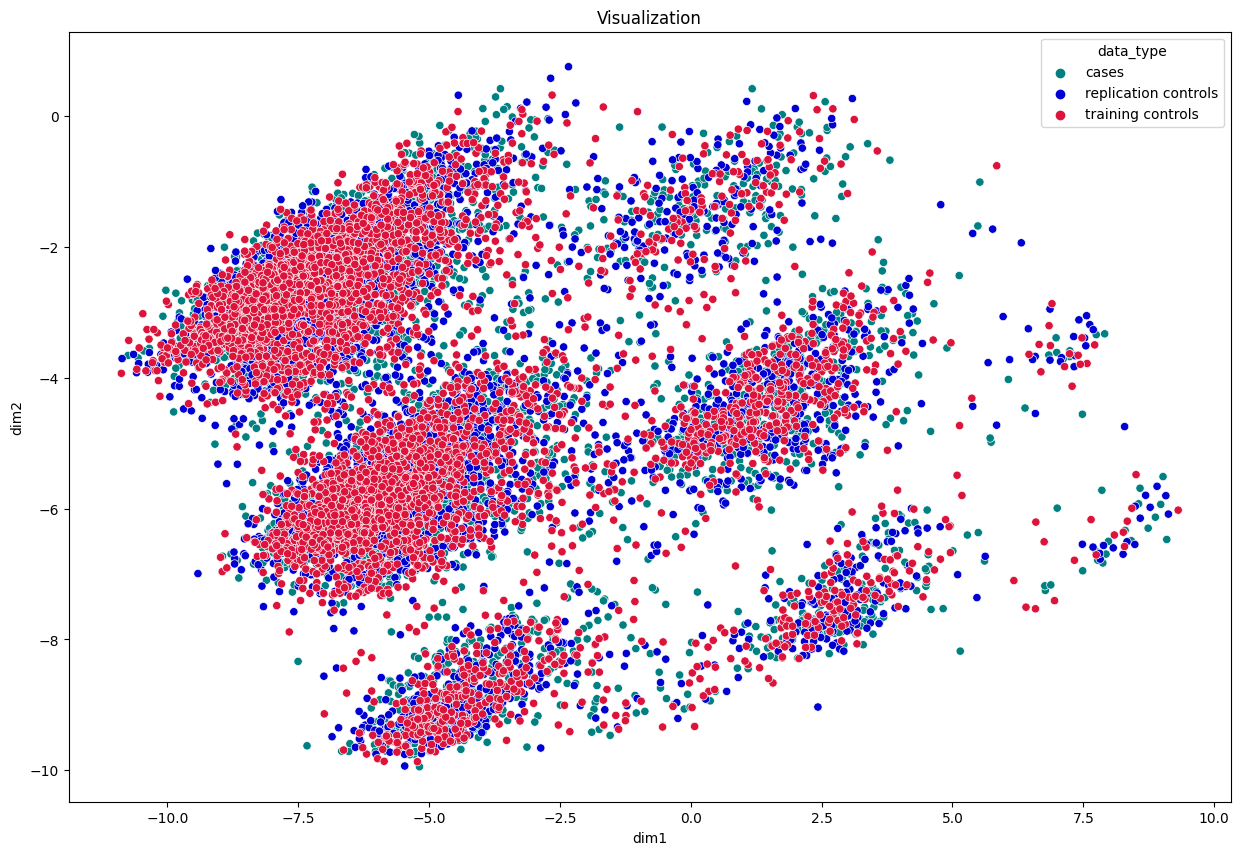

In [740]:
create_plot(test["data_type"],test, 'dim1', 'dim2','Visualization')

# Check the reconstruction error

In [741]:
X = tf.convert_to_tensor(cases_df, dtype=tf.float32)
reconstruction_cases = model(X)

In [742]:
reconstruction_errors_cases = np.mean((np.array(cases_df) - reconstruction_cases)**2, axis=1)

In [743]:
X = tf.convert_to_tensor(replicated_controls, dtype=tf.float32)
reconstruction_controls = model(X)
reconstruction_errors_controls = np.mean((np.array(replicated_controls) - reconstruction_controls)**2, axis=1)

In [744]:
X = tf.convert_to_tensor(train_controls, dtype=tf.float32)
reconstruction_train_controls = model(X)
reconstruction_errors_training = np.mean((np.array(train_controls) - reconstruction_train_controls)**2, axis=1)

In [745]:
reconstruction_errors_training

array([0.21317217, 0.2560601 , 0.20717077, ..., 0.26035658, 0.23150708,
       0.27114347], dtype=float32)

In [746]:
reconstruction_errors_cases

array([0.24656358, 0.22825092, 0.27801868, ..., 0.33515272, 0.3485664 ,
       0.28115675], dtype=float32)

In [747]:
case = pd.DataFrame(data=reconstruction_errors_cases, columns = ['reconstruction error'])
case['phenotype'] = [1] * len(case)
case['data_type'] = ['cases'] * len(case)

contr1 = pd.DataFrame(data=reconstruction_errors_training, columns = ['reconstruction error'])
contr1['phenotype'] = [0] * len(contr1)
contr1['data_type'] = ['training controls'] * len(contr1)

contr2 = pd.DataFrame(data=reconstruction_errors_controls, columns = ['reconstruction error'])
contr2['phenotype'] = [0] * len(contr2)
contr2['data_type'] = ['validation controls'] * len(contr2)

In [748]:
data = pd.concat([case, contr2], axis = 0)
#data = pd.concat([case, contr1, contr2], axis = 0)

data

,reconstruction error,phenotype,data_type
0,0.246564,1,cases
1,0.228251,1,cases
2,0.278019,1,cases
3,0.294299,1,cases
4,0.279635,1,cases
...,...,...,...
4608,0.218583,0,validation controls
4609,0.286864,0,validation controls
4610,0.299829,0,validation controls
4611,0.241615,0,validation controls


<module 'matplotlib.pyplot' from '/home/mat2m10/.pyenv/versions/3.10.6/envs/ctg/lib/python3.10/site-packages/matplotlib/pyplot.py'>

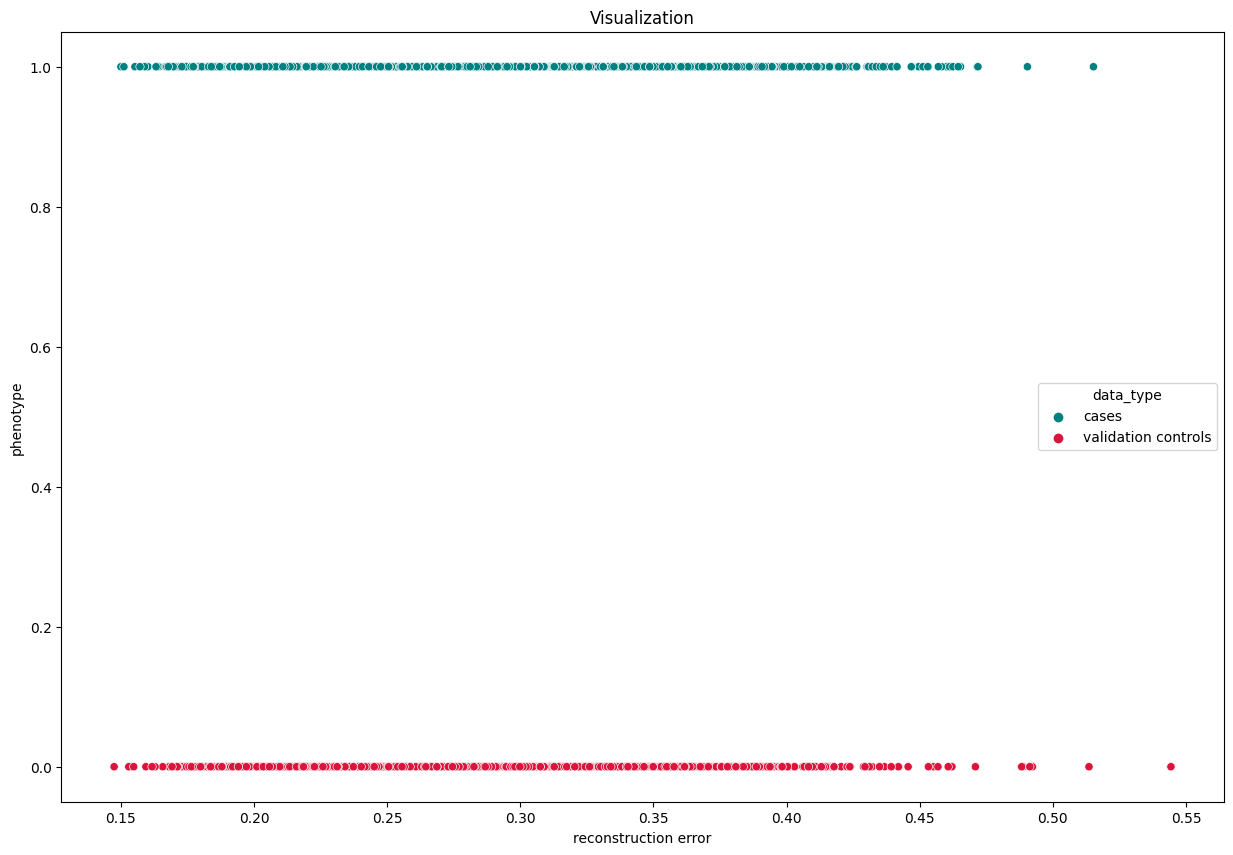

In [749]:
create_plot(data["data_type"],data, 'reconstruction error', 'phenotype','Visualization')

In [750]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [751]:
# Split the data into features (X) and labels (Y)
X = data[['reconstruction error']]
Y = data['phenotype']

# Encode the 'data_type' column if necessary
encoder = LabelEncoder()
data['data_type'] = encoder.fit_transform(data['data_type'])

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Build a simple neural network model
model = keras.Sequential([
    keras.layers.Input(shape=(1,)),  # Input layer with 1 feature
    keras.layers.Dense(64, activation='relu'),  # Hidden layer with 64 units and ReLU activation
    keras.layers.Dense(32, activation='relu'),  # Hidden layer with 32 units and ReLU activation
    keras.layers.Dense(1, activation='sigmoid')  # Output layer with 1 unit and sigmoid activation
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, Y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, Y_test)
print(f'Test accuracy: {test_accuracy * 100:.2f}%')

Epoch 1/10
185/185 [==============================] - 1s 3ms/step - loss: 0.6935 - accuracy: 0.4988 - val_loss: 0.6931 - val_accuracy: 0.5020
Epoch 2/10
185/185 [==============================] - 0s 2ms/step - loss: 0.6933 - accuracy: 0.5005 - val_loss: 0.6933 - val_accuracy: 0.5014
Epoch 3/10
185/185 [==============================] - 0s 2ms/step - loss: 0.6933 - accuracy: 0.4997 - val_loss: 0.6932 - val_accuracy: 0.5014
Epoch 4/10
185/185 [==============================] - 0s 3ms/step - loss: 0.6933 - accuracy: 0.5014 - val_loss: 0.6934 - val_accuracy: 0.4986
Epoch 5/10
185/185 [==============================] - 0s 3ms/step - loss: 0.6933 - accuracy: 0.4927 - val_loss: 0.6933 - val_accuracy: 0.4986
Epoch 6/10
185/185 [==============================] - 0s 3ms/step - loss: 0.6933 - accuracy: 0.4922 - val_loss: 0.6931 - val_accuracy: 0.4885
Epoch 7/10
185/185 [==============================] - 0s 2ms/step - loss: 0.6933 - accuracy: 0.4983 - val_loss: 0.6932 - val_accuracy: 0.4919
Epoch 

58/58 [==============================] - 0s 813us/step


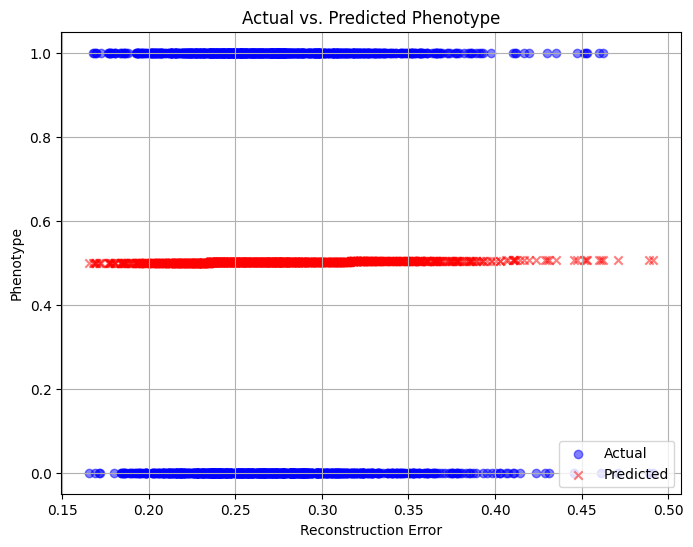

In [752]:
# Make predictions on the test data
predictions = model.predict(X_test)

# Create a scatter plot of actual vs. predicted values
plt.figure(figsize=(8, 6))
plt.scatter(X_test, Y_test, c='b', label='Actual', marker='o', alpha=0.5)
plt.scatter(X_test, predictions, c='r', label='Predicted', marker='x', alpha=0.5)
plt.xlabel('Reconstruction Error')
plt.ylabel('Phenotype')
plt.legend()
plt.title('Actual vs. Predicted Phenotype')
plt.grid(True)
plt.show()

# PRS accuracy


In [753]:
pheno = pd.read_pickle(f"{path}/pheno_PRS.pkl")

In [754]:
# Split DataFrame into controls to train the model and cases and controls to calculate PRS
cases_df = pheno[pheno['phenotype'] == 1]
controls_df = pheno[pheno['phenotype'] == 0]
controls_df = controls_df.sample(frac=1, random_state=42)
train_controls = controls_df.head(len(controls_df)//2)
replicated_controls = controls_df.tail(len(controls_df) - len(controls_df)//2)
smallest_size = min(len(train_controls), len(replicated_controls), len(cases_df))


cases_df = cases_df.head(smallest_size)
train_controls = train_controls.head(smallest_size)
replicated_controls = replicated_controls.head(smallest_size)

In [755]:
pheno = pd.concat([cases_df, replicated_controls], axis = 0)
pheno

,FID,IID,na1,na2,na3,phenotype,PRS
0,1000133,1000133,0,0,0,1,-195.823928
1,1000368,1000368,0,0,0,1,264.081506
2,1000566,1000566,0,0,0,1,285.314179
3,1000617,1000617,0,0,0,1,-10.446365
6,1001153,1001153,0,0,0,1,-454.682371
...,...,...,...,...,...,...,...
12591,4457776,4457776,0,0,0,0,-255.302690
11480,4160762,4160762,0,0,0,0,-533.914158
10375,3871586,3871586,0,0,0,0,-156.083884
10793,3976274,3976274,0,0,0,0,244.895714


In [756]:
# Split the data into features (X) and labels (Y)
X = pheno[['PRS']]
Y = pheno['phenotype']

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Build a simple neural network model
model = keras.Sequential([
    keras.layers.Input(shape=(1,)),  # Input layer with 1 feature
    keras.layers.Dense(64, activation='relu'),  # Hidden layer with 64 units and ReLU activation
    keras.layers.Dense(32, activation='relu'),  # Hidden layer with 32 units and ReLU activation
    keras.layers.Dense(1, activation='sigmoid')  # Output layer with 1 unit and sigmoid activation
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, Y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, Y_test)
print(f'Test accuracy: {test_accuracy * 100:.2f}%')

Epoch 1/10
185/185 [==============================] - 1s 3ms/step - loss: 1.0310 - accuracy: 0.5559 - val_loss: 0.7172 - val_accuracy: 0.4986
Epoch 2/10
185/185 [==============================] - 1s 3ms/step - loss: 0.7966 - accuracy: 0.5625 - val_loss: 0.7394 - val_accuracy: 0.6070
Epoch 3/10
185/185 [==============================] - 0s 2ms/step - loss: 0.8557 - accuracy: 0.5601 - val_loss: 0.8014 - val_accuracy: 0.4986
Epoch 4/10
185/185 [==============================] - 0s 2ms/step - loss: 0.8028 - accuracy: 0.5571 - val_loss: 1.7738 - val_accuracy: 0.4986
Epoch 5/10
185/185 [==============================] - 0s 3ms/step - loss: 0.7797 - accuracy: 0.5733 - val_loss: 0.6757 - val_accuracy: 0.5894
Epoch 6/10
185/185 [==============================] - 0s 3ms/step - loss: 0.7434 - accuracy: 0.5783 - val_loss: 0.6568 - val_accuracy: 0.6118
Epoch 7/10
185/185 [==============================] - 0s 3ms/step - loss: 0.7447 - accuracy: 0.5720 - val_loss: 0.9996 - val_accuracy: 0.5108
Epoch 